In [3]:
import numpy as np
import xarray as xr
from numpy import ma
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature
import pandas as pd
from sklearn.decomposition import pca
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd

from MapXtremePCIC import MapXtremePCIC

In [4]:
PATH = './data/pr_24hr_50yrs/'

MapXtreme = MapXtremePCIC('110m', 'eof', PATH, 'pr')
data_cube = MapXtreme.load_data

In [5]:
#y_g = MapXtremePCIC.sample(MapXtreme, frac = .05, seed = 7, dropna = True)
dfo = MapXtremePCIC.sample(MapXtreme, frac = 1, seed = 7, dropna = True) # CanRCM4 simulation
y_g = dfo.sample(frac = 0.02) # pseudo observations

In [11]:
y_g['obs_y'] = y_g['run1'].values
df = pd.concat([y_g['obs_y'], dfo], axis=1).dropna()

scaler = StandardScaler()
y_g_arr = MapXtremePCIC.ensemble_mean(MapXtreme, y_g)[0, :]
y_g_arr.shape

(177,)

In [12]:
df['frac_area'] = df['areas']/df['areas'].sum()
dfo['frac_area'] = dfo['areas']/dfo['areas'].sum()


Xp = MapXtremePCIC.ensemble_mean(MapXtreme, df)
Xpo = MapXtremePCIC.ensemble_mean(MapXtreme, dfo)

W = np.diag(df['frac_area'].values)
Wo = np.diag(dfo['frac_area'].values)

X = np.dot(Xp, W)
Xo = np.dot(Xpo, Wo)
y_w = np.dot(y_g_arr, W)

U, s, V = svd(X)
Uo, so, Vo = svd(Xo)

U.shape, s.shape, V.shape

((35, 35), (35,), (177, 177))

In [13]:
#dfo.plot.scatter('rlon', 'rlat', s=0.5)
#dfo.plot.scatter('rlon', 'areas', s=0.5)
#dfo.plot.scatter('rlat', 'areas', s=0.5)

(124, 149)


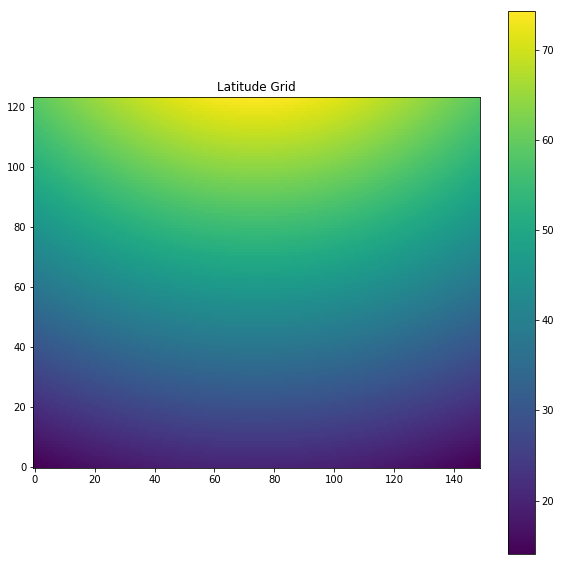

In [60]:
print(data_cube['lat'].shape)
plt.figure(figsize=(10, 10))
plt.imshow(data_cube['lat'])
plt.title('Latitude Grid')
plt.gca().invert_yaxis()
plt.colorbar()

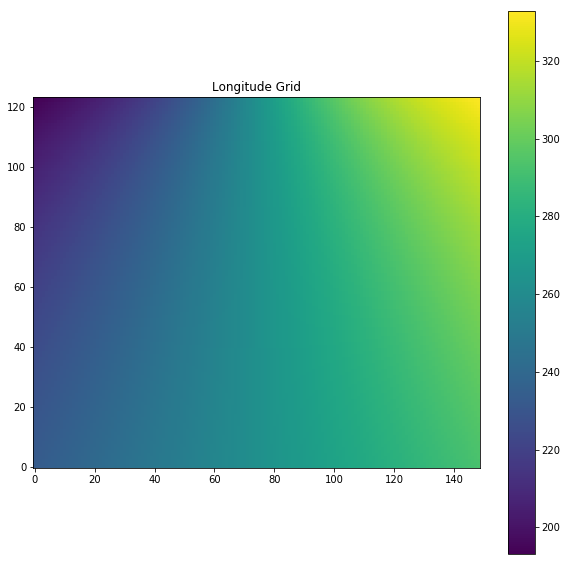

In [61]:
plt.figure(figsize=(10, 10))
plt.imshow(data_cube['lon'])
plt.title("Longitude Grid")
plt.gca().invert_yaxis()
plt.colorbar()

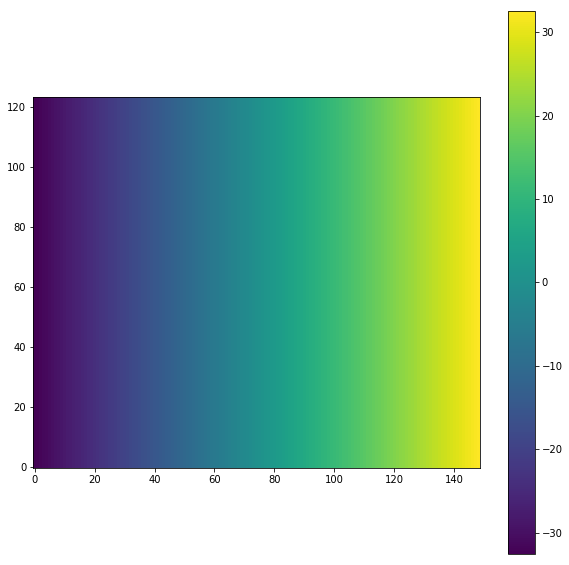

In [62]:
np.tile(data_cube['rlon'], data_cube['rlat'].shape[0])
x = np.meshgrid(data_cube['rlon'], data_cube['rlat'])
plt.figure(figsize=(10, 10))
plt.imshow(x[0])
plt.gca().invert_yaxis()
plt.colorbar()

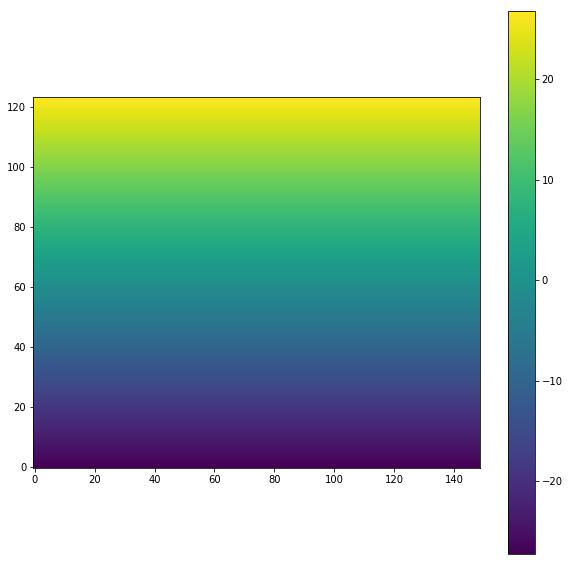

In [63]:
plt.figure(figsize=(10, 10))
plt.imshow(x[1])
plt.gca().invert_yaxis()
plt.colorbar()

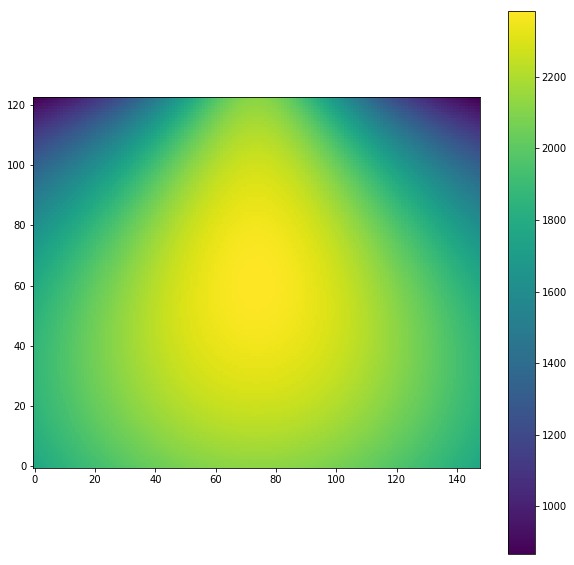

In [64]:
# calculate the differences along each axis to get grid
# cell size - shape is 1 smaller because the 
ds = MapXtreme.load_data

lat = np.deg2rad(ds['lat'].values[:-1, :-1])

R = 6371.
p = lat.shape[0]*lat.shape[1]

lat_sz = np.abs(np.diff(np.sin(np.deg2rad(ds['lat'].values)), axis=0)[:, :-1])
lon_sz = np.abs(np.deg2rad(np.diff(ds['lon'].values, axis=1)[:-1, :]))

# calculate rectangular area on sphere
area = (lat_sz * lon_sz) * R**2

plt.figure(figsize=(10, 10))
plt.imshow(area)
plt.gca().invert_yaxis()
plt.colorbar()

[3.49470401e-03 7.77633389e-05]


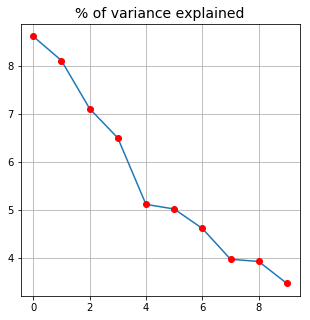

In [14]:
skpca = pca.PCA()
skpca.fit(X)

f, ax = plt.subplots(figsize=(5,5))
ax.plot(skpca.explained_variance_ratio_[0:10]*100)
ax.plot(skpca.explained_variance_ratio_[0:10]*100,'ro')
ax.set_title("% of variance explained", fontsize=14)
ax.grid()

ipc = np.where(skpca.explained_variance_ratio_.cumsum() >= 0.95)[0][0]
ipc

PCs = skpca.transform(X)
PCs = PCs[:,:ipc]

EOFs = skpca.components_
EOFs = EOFs[:ipc,:]

#f = []
#for k in range(ipc):
# Start with k = 0, or first principal component
x = V[0, :] # check that k is on the right axis????
z = np.polyfit(x, y_w,  deg = 1)
print(z)
f = np.poly1d(z)
Vo_eof = f(Vo[0, :])
dfo['eof'] = Vo_eof

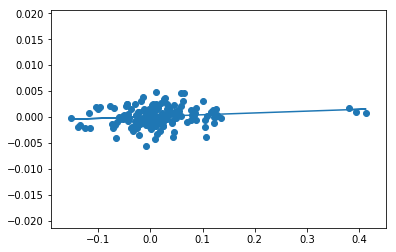

In [15]:
#dfo['eof'] = np.dot(Vo_eof, np.linalg.inv(Wo))
plt.scatter(x, y_w)
plt.plot(x, f(x))

In [16]:
#MapXtremePCIC.plot_reference(MapXtreme)

In [17]:
rlat, rlon = dfo['rlat'].values, dfo['rlon'].values
N = np.dot(dfo['eof'].values, np.linalg.inv(Wo))
########### CONVERT BACK TO NON-NORMALIZED

In [18]:
N_n = (N + y_g_arr.mean())

In [19]:
N_n

array([0.27299647, 0.57398354, 0.76568576, ..., 0.77161608, 0.9126318 ,
       1.75869249])

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

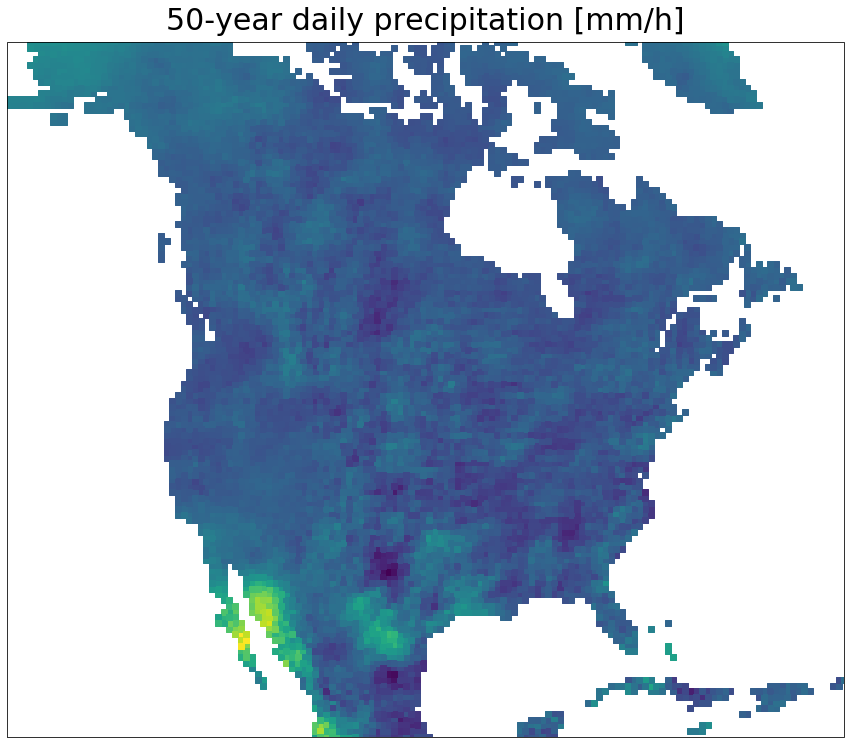

In [22]:
rp = MapXtremePCIC.rp()
ocean = MapXtremePCIC.ocean_mask('50')
#cmap = MapXtremePCIC.color_pallette()

plt.figure(figsize = (15, 15))

# define projections
ax = plt.axes(projection=rp)#ccrs.PlateCarree())
#x
ax.set_title('50-year daily precipitation [mm/h]', fontsize=30, verticalalignment='bottom')
#ax.add_feature(ocean, zorder=2)

# plot design values with custom colormap
colorplot = ax.scatter(rlon, rlat, c = N, marker='s')#, cmap=cmap, vmin=1., vmax=13.)
#cbar = plt.colorbar(colorplot, ax=ax, orientation="horizontal", fraction=0.07, pad=0.025)
#cbar.ax.tick_params(labelsize=25)

# constrain to data
plt.xlim(rlon.min(), rlon.max())
plt.ylim(rlat.min(), rlat.max())

# return/undo the supress invalid warning
np.seterr(invalid = 'warn')

Index(['rlon', 'rlat', 'areas', 'obs', 'obs', 'obs', 'obs', 'obs', 'obs',
       'obs', 'obs', 'obs', 'obs', 'obs', 'obs', 'obs', 'obs', 'obs', 'obs',
       'obs', 'obs', 'obs', 'obs', 'obs', 'obs', 'obs', 'obs', 'obs', 'obs',
       'obs', 'obs', 'obs', 'obs', 'obs', 'obs', 'obs', 'obs', 'obs'],
      dtype='object')